# Tutorial: Geometric Generator Models

<h1>Introduction</h1>
In this tutorial, we'll explore the geometric network generator models implemented in networkx under networkx/generators/geometric.py and apply them to a real-world use case to learn how these models can be parameterized and used.

<h2>Geometric/Spatial Networks</h2>
Many real-world complex systems have spatial components constraining the network structures these types of systems can produce. Infrastructure networks such as transportation, electrical, and telecommunication systems, social networks and even our own synaptic networks are all embedded in physical space. Spatial Networks provide a framework for network models having spacial elements where nodes are embedded in space and a metric is incorporated that dictates the conditions for connection between nodes. Typically, the probability of connection is a decreasing function of the metric, with most models assuming euclidean distance in 2-dimensions or 3-dimensions. The intuition of most Spatial Network models propose that there exists an increasing cost of connection between nodes that are further apart, though arbitrary connection probability functions can be modeled.

The potential application of Spatial Networks to such a wide variety of real-world systems has motivated substainial research into these networks, with many unique but closely related models being proposed with theoretical proofs for many of their network properties. The 2010 Spatial Networks review article by Marc Barthélemy[1] provides a comprehensive overview of the field and reviews many of the most important theoretical proofs for the most common Spatial Network models. Here we explore some of the most typical Spatial Network models which have been implemented in the networkx package. These models can be classified using only three model parameters used by these different models.


R - The maximum connection distance, the 'radius' parameter in networkx   
P(d<sub>ij</sub>) - The probability of edge connection as a function of the distance, d<sub>ij</sub>, between nodes i,j where i ≠ j, the 'p_dist' parameter in networkx  
Θ - The node weight threshold for connection, the 'theta' parameter in networkx

Typically, nodes are uniformly distributed onto the unit square and node weights are sampled from some weight distribution. Distance, d<sub>ij</sub> is typically assumed to be the Euclidean distance, but some networkx models allow custom metrics where others only allow Minkowski distance metrics.

Figure below shows the relationships between Spatial Network Models connected by their shared parameterization.

![spatial_networks](images/spatial_networks.png "Spatial Networks")

<h3>Individual Model Definitions</h3>
This section summarizes the various models. The notation E<sub>ij</sub> indicates an edges exists between nodes i and j.

<h4>Random Geometric Graphs (R)</h4>
A d-dimensional Random Geometric Graph (RGG) is a graph where each of the N nodes is assigned random coordinates in the box [0, 1]<sup>d</sup>, and only nodes ‘close’ to each other are connected by an edge[2]. Any node within or equal to the maximum connection distance, R, is a connected node and the structure of the network is fully defined by R. RGGs, similar to Unit Disk Graphs [3],  have been widely used to model ad-hoc wireless networks[12].

(1) E<sub>ij</sub>: d<sub>ij</sub> ≤ R

<h4>Waxman Graphs (α)</h4>
Waxman Graphs are the spatial generalization of ER random graphs, where the probability of connection of nodes depends on a function of the distance between them[4]. The original edge probabiliy function proposed by Waxman is exponential in d<sub>ij</sub>, providing two connection probability tuning parameters, α and β:  

(2)  P(d<sub>ij</sub>) = βe<sup>-d<sub>ij</sub>/Lα</sup>         
Where L is the maximum distance between each pair of nodes

The shape of the edge probabiliy function, P(d<sub>ij</sub>), plays the key role in determining the structure of a Waxman graph, but characterization of P(d<sub>ij</sub>) in real-world networks still seems controversial [8]. The most commonly studied functional families are the orginal exponential in Equation 1, or power laws, -d<sub>ij</sub><sup>-α</sup>.

(3) E<sub>ij</sub> ∝ P(d<sub>ij</sub>)

<h4>Threshold Graphs (Θ)</h4>
A simple graph G is a threshold graph if we can assign weights to the vertices such that a pair of distinct vertices is adjacent exactly when the sum of their assigned weights is or exceeds a specified threshold, Θ [6]. Threshold Graphs are not themselves Spatial Networks, as they do not incorporate a specific geometry or metric, but they introduce the ability to consider node weights as part of the network model which is utilized by other Spatial Network models such as Geometric Threshold Graphs.  

(4) E<sub>ij</sub>: (w<sub>i</sub> + w<sub>j</sub>) ≥ Θ

<h4>Geographical Threshold Graphs (P(d<sub>ij</sub>),Θ)</h4>
Geographical Threshold Graphs are the geographical generalization of Threshold Graphs, where a pair of vertices with weights w<sub>i</sub>, w<sub>j</sub>, and distance d<sub>ij</sub> are connected if and only if the product between the sum of weights  w<sub>i</sub> and w<sub>j</sub> with the edge connection function, P(d<sub>ij</sub>), is greater than or equal to a threshold value, Θ. [8]

(5) E<sub>ij</sub>: (w<sub>i</sub> + w<sub>j</sub>)P(d<sub>ij</sub>) ≥ Θ

<h4>Soft Random Geometric Graphs (R,P(d<sub>ij</sub>))</h4>
A recent extention of Random Geometric Graphs couples the influence of distance between nodes that are within the maximum connection distance, R, to better model real-world systems where node proximity does not necessarily gaurantee a connection between 'close' nodes. In Soft Random Geometric Graphs, the probability  of connection between nodes i and j is a function of their distance, d<sub>ij</sub>, if d<sub>ij</sub> ≤ R. Otherwise, they are disconnected [7].

(6) E<sub>ij</sub> ∝ P(d<sub>ij</sub>) if d<sub>ij</sub> ≤ R

<h4>Thresholded Random Geometric Graphs (R,Θ)</h4>
Thresholded Random Geometric Graphs extend RGGs to incorporate node weights into the model, where connections are only made between nodes with sufficiently powerful weights, up to a maximum connection distance between nodes [9].   

(7) (w<sub>i</sub> + w<sub>j</sub>) ≥ Θ if d<sub>ij</sub> ≤ R

<h3>A Motivating Example</h3>
For this tutorial, we'll use the Tesla North American Supercharger network as a motivating example to highlight how the various spatial network models implemented in networkx can be parameterized and used.

![spatial_networks](images/NA-Supercharger_Network.jpg "Tesla Supercharger Network")

The Supercharger data is obtained from supercharger.info, filtered for the Canadian and American Supercharger locations, totaling 385 Opened Superchargers as of April 2017. The collected data has been structure into a Networkx Graph which is made up of nested dictionaries keyed on the geohash of each Superchargers GPS coordinates which have been converted into a projected embedding onto the unit square. Node weights are the population of cities for each Supercharger, as a percent of total North American population. With this dataset, we can model the supercharger network with the various spatial networks implemented in networkx.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# from networkx.readwrite import json_graph
import json

#load json-ed networkx datafile
with open('data/tesla_network.json','r') as infile:
    G = nx.json_graph.node_link_graph(json.load(infile))

In [3]:
print('Node Count = %s' %(len(G.nodes())))

Node Count = 385


In [4]:
#example node data structure keyed on geohash of GPS cords
G.nodes['dr7k46ycwwb8']

{'SC_index': 173,
 'geohash': 'dr7k46ycwwb8',
 'weight': 0.00014093906625032375,
 'GPS_lon_lat': [-74.07126104459167, 41.49977498687804],
 'lat': 41.49977498687804,
 'lon': -74.07126104459167,
 'population': 28101,
 'pos': [0.8123107474668945, 0.42622282744786055],
 'GPS': [41.49977498687804, -74.07126104459167]}

In [5]:
#extract pos and weight attributes for use in models
nodes = G.nodes()
pos = nx.get_node_attributes(G, 'pos')
weight = nx.get_node_attributes(G, 'weight')

<h1>Random Geometric Graphs</h1>
For RGGs, we see the impact of increasing the maximum connection distance parameter, radius, in increasing the number of connections.

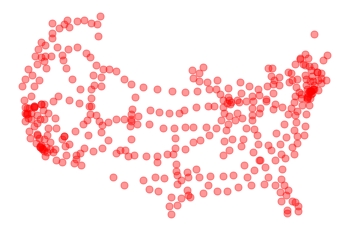

In [6]:
fig, ax = plt.subplots()
RGG = nx.random_geometric_graph(nodes, 0, pos=pos)
nx.draw(RGG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r')

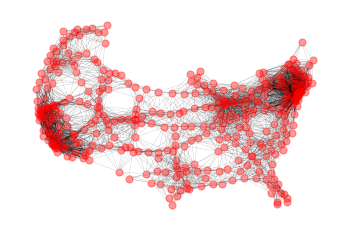

In [7]:
fig, ax = plt.subplots()
RGG = nx.random_geometric_graph(nodes, 0.1, pos=pos)
nx.draw(RGG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.2)

In [8]:
fig, ax = plt.subplots()
RGG = nx.random_geometric_graph(nodes, 0.2, pos=pos)
nx.draw(RGG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.2)

Error in callback <function flush_figures at 0x7eff968b6ee0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
RGG = nx.random_geometric_graph(nodes, 0.3, pos=pos)
nx.draw(RGG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.1)

<h1>Waxman Graphs</h1>

<h1>Geographical Threshold Graphs</h1>
The GTG model allows for a wide range of custom parameters including custom node positioning, weights, metric between nodes and the probability of connection, P(d<sub>ij</sub>). The default P(d<sub>ij</sub>) model is the metric value, r, for the two connecting nodes raised to the -alpha parameter, which has a default value of 2.

In [ ]:
fig, ax = plt.subplots()
GTG = nx.geographical_threshold_graph(nodes,0.1,pos=pos,weight=weight)
nx.draw(GTG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.3)

In [ ]:
fig, ax = plt.subplots()
#supply a custom metric
dist = lambda x, y: sum(abs(a - b) for a, b in zip(x, y))
GTG = nx.geographical_threshold_graph(nodes,0.1,pos=pos,weight=weight,metric=dist)
nx.draw(GTG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.3)

In [ ]:
fig, ax = plt.subplots()
#Supply a custum p_dist probability of connection function
import math
def custom_p_dist(dist):
    return math.exp(-dist)
GTG = nx.geographical_threshold_graph(nodes,0.01,pos=pos,weight=weight,metric=dist,p_dist=custom_p_dist)
nx.draw(GTG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.3)

In [ ]:
fig, ax = plt.subplots()
#We can use scipy built-in probability distributions .pdf method for our p_dist
from scipy.stats import norm
GTG = nx.geographical_threshold_graph(nodes,0.01,pos=pos,weight=weight,metric=dist,p_dist=norm(loc=0.1,scale=0.1).pdf)
nx.draw(GTG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.3)

<h1>Soft Random Geometric Graphs</h1>
SRGGs utilize the maximum connection distance parameter, R, of RGGs but provide the ability to input an arbitrary connection probability function, P(d<sub>ij</sub>), for nodes within the maximum connection distance. The default P(d<sub>ij</sub>) function for SRGGs in networkx is an exponential distribution with rate parameter lambda=1.

In [ ]:
fig, ax = plt.subplots()
SRGG = nx.soft_random_geometric_graph(nodes,0.1,pos=pos)
nx.draw(SRGG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.3)

In [ ]:
fig, ax = plt.subplots()
#Supply a custum p_dist probability of connection function
import math
def custom_p_dist(dist):
    return math.exp(-10*dist)
SRGG = nx.soft_random_geometric_graph(nodes,0.1,pos=pos,p_dist=custom_p_dist)
nx.draw(SRGG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.3)

In [ ]:
fig, ax = plt.subplots()
#We can use scipy built-in probability distributions .pdf method for our p_dist
from scipy.stats import norm
SRGG = nx.soft_random_geometric_graph(nodes,0.1,pos=pos,p_dist=norm(loc=0.1,scale=0.1).pdf)
nx.draw(SRGG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.3)

<h1>Thresholded Random Geometric Graphs</h1>
TRGGs allow for the coupling of the maximum connection distance and threshold parameters. The default weights for TRGG are drawn from an exponential distribution with rate parameter lambda=1.

In [ ]:
fig, ax = plt.subplots()
#default TRGG weight distribution network
TRGG = nx.thresholded_random_geometric_graph(nodes,0.1,0.0001,pos=pos,weight=weight)
nx.draw(TRGG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.3)

In [ ]:
fig, ax = plt.subplots()
#Increased threshold parameter, theta, reduces graph connectivity
TRGG = nx.thresholded_random_geometric_graph(nodes,0.1,0.001,pos=pos,weight=weight)
nx.draw(TRGG, pos=pos, ax=ax, alpha=0.4, node_size=50, node_color='r', width=0.3)

<h1>References</h1>

[1] - Spatial Networks https://arxiv.org/pdf/1010.0302.pdf

[2] - Random Geometric Graphs https://arxiv.org/pdf/cond-mat/0203026.pdf

[3] - Unit Disk Graphs http://www.sciencedirect.com/science/article/pii/0012365X9090358O

[4] - Waxman Graphs - http://ieeexplore.ieee.org/document/12889/

[5] - Waxman Graph Parameter Estimation - https://arxiv.org/pdf/1506.07974.pdf

[6] - Threshold Graphs - http://www.combinatorics.org/ojs/index.php/eljc/article/view/v16i1r130/pdf

[7] - Soft Geometric Random Graphs - https://arxiv.org/pdf/1311.3897.pdf

[8] - Geometric Threshold Graphs - https://arxiv.org/pdf/cond-mat/0409378.pdf

[9] - Thresholded Random Geometric Graphs - http://cole-maclean.github.io/blog/files/thesis.pdf